## Agente Planejador-Executor

In [15]:
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model_name="gemini-1.5-flash")

In [23]:
# Definindo o estado

import operator
from typing_extensions import TypedDict
from typing import Annotated, List, Tuple

class StatePlan(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [17]:
# Estrutura de resposta do LLM para a etapa de planejamento

from pydantic import BaseModel, Field

class Plan(BaseModel):
    steps: List[str] = Field(
        description="diferentes etapas a seguir, devem estar em ordem de classificação"
    )

In [18]:
# Nó de planejamento

from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Para o objetivo dado, crie um plano simples passo a passo. \
            Este plano deve envolver tarefas individuais que, se executadas corretamente, produzirão a resposta correta. Não adicione nenhuma etapa supérflua. \
            O resultado da etapa final deve ser a resposta final. Certifique-se de que cada etapa tenha todas as informações necessárias - não pule etapas"
        ),
        (
            "placeholder",
            "{messages}"
        ),
    ]
)

planner = planner_prompt | llm.with_structured_output(Plan)

In [19]:
# Testando o planner

planner.invoke(
    {
        "messages": [
            ("user", "Olá imobiliária stylus, tem apartamentos para alugar na varjota (fortaleza-ce)?")
        ]
    }
)


Plan(steps=['Verificar se a imobiliária Stylus possui apartamentos para alugar na Varjota (Fortaleza-CE).', 'Se houver, informar os detalhes dos apartamentos disponíveis (endereço, tipo, preço, etc.).', 'Se não houver, informar que não há apartamentos disponíveis na Varjota (Fortaleza-CE).'])

In [20]:
# Etapa de replanejamento

from typing import Union

class Response(BaseModel):
    """Responder ao usuário"""
    response: str

class Act(BaseModel):
    """Ação a ser executada"""

    action: Union[Response, Plan] = Field(
        description="Ação a ser executada. Se você quiser responder ao usuário, use Response. "
        "Se você precisar usar mais ferramentas para obter a resposta, use Plan."
    )

replanner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Para o objetivo dado, crie um plano simples passo a passo. \
            Este plano deve envolver tarefas individuais que, se executadas corretamente, produzirão a resposta correta. Não adicione etapas supérfluas. \
            O resultado da etapa final deve ser a resposta final. Certifique-se de que cada etapa tenha todas as informações necessárias - não pule etapas.

            Seu objetivo era este:
            {input}

            Seu plano original era este:
            {plan}

            Você atualmente fez as seguintes etapas:
            {past_steps}

            Atualize seu plano adequadamente. Se não forem necessárias mais etapas e você puder retornar ao usuário, responda com isso. Caso contrário, preencha o plano. Adicione apenas etapas ao plano que ainda PRECISAM ser feitas. Não retorne etapas feitas anteriormente como parte do plano."""
        ),
        (
            "placeholder",
            "{messages}"
        )
    ]
)

replanner = replanner_prompt | llm.with_structured_output(Act)

Key '$defs' is not supported in schema, ignoring


In [26]:
# elaborando as funções dos nós

from langgraph.graph import END

async def execute_step(state: StatePlan):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""
        Para o seguinte plano: {plan_str}\n\n
        Você é responsável pela tarefa {1}: {task}.
    """
    agent_response = await llm.ainvoke(
        {
            "messages": [
                ("user", task_formatted)
            ]
        }
    )

    return {
        "past_steps": [(task, agent_response["messages"][-1].content)]
    }

async def plan_step(state: StatePlan):
    plan = await planner.ainvoke(
        {
            "messages": [
                ("user", state["input"])
            ]
        }
    )

    return {
        "plan": plan.steps
    }

async def replan_steps(state: StatePlan):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.acition.steps}
    
async def should_end(state: StatePlan):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [ ]:
# Construindo o gráfico

from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

graph_builder = StateGraph(StatePlan)

# Definindo os nós
graph_builder.add_node("planner", plan_step)
graph_builder.add_node("agent", execute_step)
graph_builder.add_node("replan", replan_steps)

# Definindo as pontes
graph_builder.add_edge(START, "planner")
graph_builder.add_edge("planner", "agent")
graph_builder.add_edge("agent", "replan")
graph_builder.add_conditional_edges("replan", should_end, ["agent", END])

# Compilando o grafo
app = graph_builder.compile()

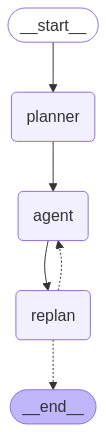

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))